## 保存和加载训练过的神经网络

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
train_set = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Download and load the test data
test_set = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

## 神经网络

In [6]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p):
        super().__init__()
        
        ## 输入层（第1个隐藏层）
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        
        ## 扩展隐藏层
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        ## 输出层
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        ## dropout
        self.dropout = nn.Dropout(p=drop_p)
    
    def forward(self, x):
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)
        

In [7]:
model = Network(784, 10, [500], drop_p=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
## 训练网络
epochs = 2
steps = 0
running_loss = 0
print_every = 40

for e in range(epochs):
    ## 训练模式下，dropout开启
    model.train()
    for images, labels in iter(train_loader):
        steps += 1
        images.resize_(images.shape[0], 784)
        
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = model.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            ## 推断模式（预测）下，关闭dropout
            model.eval()
            
            accuracy = 0
            test_loss = 0
            
            for ii, (images, labels) in enumerate(test_loader):
                images = images.resize_(images.shape[0], 784)
                with torch.no_grad():  # 不计算梯度
                    inputs = Variable(images)
                    labels = Variable(labels)
                    
                    output = model.forward(inputs)
                    test_loss += criterion(output, labels).item()
                    
                    ## output为对数概率，要进行exp
                    ps = torch.exp(output).data
                    equality = (labels.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                          "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
            running_loss = 0
                    
            # 开启dropout
            model.train()

Epoch: 1/2..  Training Loss: 1.043..  Test Loss: 0.717..  Test Accuracy: 0.738
Epoch: 1/2..  Training Loss: 0.691..  Test Loss: 0.622..  Test Accuracy: 0.757
Epoch: 1/2..  Training Loss: 0.657..  Test Loss: 0.625..  Test Accuracy: 0.769
Epoch: 1/2..  Training Loss: 0.610..  Test Loss: 0.539..  Test Accuracy: 0.802
Epoch: 1/2..  Training Loss: 0.587..  Test Loss: 0.528..  Test Accuracy: 0.805
Epoch: 1/2..  Training Loss: 0.584..  Test Loss: 0.552..  Test Accuracy: 0.796
Epoch: 1/2..  Training Loss: 0.589..  Test Loss: 0.534..  Test Accuracy: 0.795
Epoch: 1/2..  Training Loss: 0.550..  Test Loss: 0.516..  Test Accuracy: 0.813
Epoch: 1/2..  Training Loss: 0.507..  Test Loss: 0.497..  Test Accuracy: 0.818
Epoch: 1/2..  Training Loss: 0.530..  Test Loss: 0.479..  Test Accuracy: 0.826
Epoch: 1/2..  Training Loss: 0.490..  Test Loss: 0.480..  Test Accuracy: 0.823
Epoch: 1/2..  Training Loss: 0.528..  Test Loss: 0.496..  Test Accuracy: 0.817
Epoch: 1/2..  Training Loss: 0.579..  Test Loss: 0.4

## 保存模型

In [9]:
## 查看权重系数
print('Our model: \n\n', model, '\n')
print('The state dict keys: \n\n', model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
  )
  (output): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'output.weight', 'output.bias'])


In [11]:
## 保存
torch.save(model.state_dict(), 'test.m')

## 加载模型

In [12]:
state_dict = torch.load('test.m')

In [13]:
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'output.weight', 'output.bias'])


In [14]:
## 创建初始模型
model_new = Network(784, 10, [500], drop_p=0.5)
model_new.load_state_dict(state_dict)

D:\ProgramData\Anaconda3\envs\udacity\lib\site-packages\ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


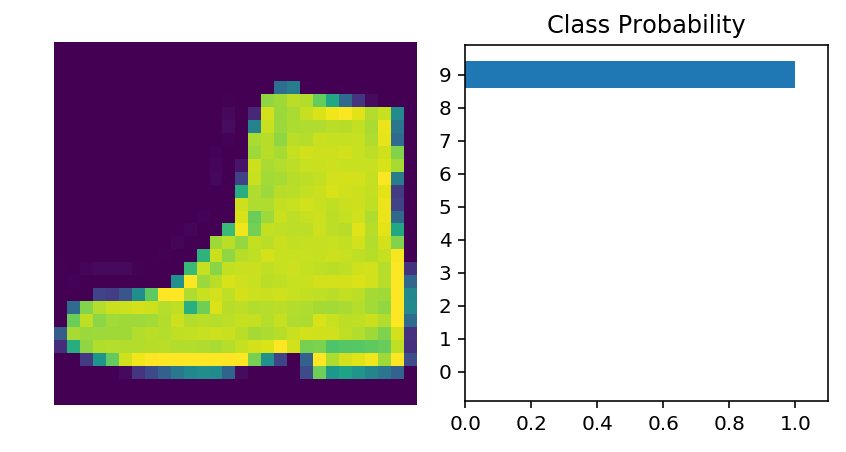

In [15]:
## 预测
model_new.eval()

images, labels = next(iter(test_loader))
img = images[1]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model_new.forward(Variable(img))
    ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps)

## 可能产生的错误

In [16]:
## 如果创建的初始模型与加载的模型不一致
model1 = Network(784, 10, [500, 100], drop_p=0.3)
model1.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	Missing key(s) in state_dict: "hidden_layers.1.weight", "hidden_layers.1.bias". 
	size mismatch for output.weight: copying a param with shape torch.Size([10, 500]) from checkpoint, the shape in current model is torch.Size([10, 100]).

## 从上述错误可以看出，创建的初始模型的参数需要与加载的模型参数${\color{red}{一致}}$

In [17]:
## 将参数信息与模型参数一起保存
parameters = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}
torch.save(parameters, 'test1.m')

In [20]:
def load_model(path):
    model_info = torch.load(path)
    model = Network(model_info['input_size'], model_info['output_size'], model_info['hidden_layers'], drop_p=0.3)
    model.load_state_dict(model_info['state_dict'])
    
    return model

In [21]:
model2 = load_model('test1.m')

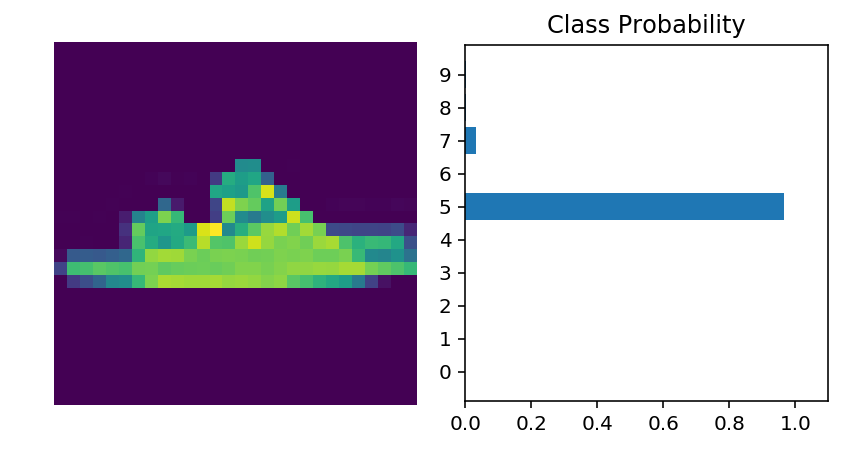

In [22]:
## 预测
model2.eval()

images, labels = next(iter(test_loader))
img = images[1]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model2.forward(Variable(img))
    ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps)